# Classification Analysis of Patient Parameters on Stroke Predictions

In [1]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
install.packages("generics")
install.packages("themis")
require(themis)

set.seed(1768)
options(repr.matrix.max.rows = 6)
options(repr.plot.width = 8, repr.plot.width= 10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0     ✔ recipes   0.2.0
✔ dials     0.0.9     ✔ rsample   0.0.7
✔ infer     0.5.4     ✔ tune      0.1.1
✔ modeldata 0.0.2     ✔ workflows 0.2.0
✔ parsnip   0.1.3     ✔ yards

## Introduction

According to the World Health Organization (WHO), strokes are the second leading cause of death globally responsible for approximately 11% of total deaths. A stroke occurs when a blood vessel carrying oxygen and nutrients to the brain is either blocked by clots or bursts due to ruptures. This results in a lack of blood and oxygen flow to the brain and causes brain cells to die.

Given a patient data collection of parameters and measurements, can we predict whether or not a patient previously had a stroke? At large, the factors of interest are categorized as reported modifiable risk factors, unlike sex, age and ethnicity which are classified as unmodifiable, and are ultimately hereditary. Modifiable risk factors are usually environmental influences that might raise the risk for stroke in certain people. These modifiable risk factors will make up our predictors of interest.

The dataset obtained is used to predict whether a patient is likely to have had a stroke based on input parameters such as gender, age, various diseases, and smoking status. Each row in the data provides relevant information about the patient. In total, there are 5110 observations with respect to 12 attribute parameters.

Attribute Information
- 1) id: unique identifier
- 2) gender: "Male", "Female" or "Other"
- 3) age: age of the patient
- 4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- 5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- 6) ever_married: "No" or "Yes"
- 7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- 8) Residence_type: "Rural" or "Urban"
- 9) avg_glucose_level: average glucose level in blood
- 10) bmi: body mass index
- 11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
- 12) stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

## Methods and Results

We will be conducting data analysis via classification on stroke using predictors of interest. We will model our analysis using predictors based on exploratory data anlysis and research articles to support our choice of predictors. Furthermore, we will be using forward selection (Eforymson 1966; Draper and Smith 1966) in order to obtain insight on finding the best subset of predictors. 

Accuracy will be evaluated via data splits of training and testing sets and resultingly evaluating the accuracy of the classifier. This will be done with randomness via seeds to model reproducibility along with analysis via cross-validation, K-nearest neighbor algorithm parameter selections, retraining, and model evaluation. The model will be graphed using a scatter plot to measure the accuracy of the predictions and classifier along with a confusion matrix.

Furthurmore, the class imbalances seen in the stroke dataset may cause poor performance in K-nearest neighbours classification. The dataset contains more cases of no strokes than cases of strokes and will cause problems in the K-nearest neighbor classification algorithm due to imbalances. Despite the knowledge required to correct for these imalances, we will still attempt to correct these imbalances by upsampling our classes for classification. This will lead to a fundamental issue that leads to overfitting of the model as it increase the number of cases in each class to match the most prevalent class which would be the case of no strokes. For this reason, cross-validation will not work as desired with upsampling and should be noted for future experimental research and analysis.

Hypertension is the most important modifiable risk factor for stroke, with a strong and continuous relationship between blood pressure and stroke risk (Hägg-Holmberg et al., 2019). Even among those who are not necessarily hypertensive, the higher the blood pressure, the higher the risk of stroke. Blood pressure (regardless of hypertension), rises with increasing age, thereby increasing the lifetime risk of developing this condition. Hence, hypertension (modifiable) is heavily correlated with age (unmodifiable).

Body weight and obesity are risk factors for stroke. Obesity is related to stroke risk factors such as hypertension and diabetes. Recent data found that 76% of the effect of BMI on stroke risk was mediated by blood pressure, cholesterol, and glucose levels (Boehme et al., 2017). Blood pressure solely accounted for 65% of the risk because of weight.

Stroke risk was nearly doubled in patients with impaired glucose tolerance (range from 140.4-198 mg/dL) compared with those with normal glucose levels (80 mg/dL- 126mg/dL), and nearly tripled in diabetic patients (glucose≥ 198 mg/dL) (Boehme et al., 2017). Patients with low glucose levels (<80mg/dL) had a 50% increased stroke risk compared with those with normal glucose levels.

Smoking remains a major risk factor for stroke, nearly doubling the risk and contributing to 15% of all stroke deaths per year (Boehme et al., 2017). Smoking cessation rapidly reduces the risk of stroke, with added risk nearly disappearing 2 to 4 years after smoking cessation.

From the supplementary research articles, we will be utaliizing the modifiable risk factors as predictors for determining whether a patient preiviously had a stroke instance.


In [2]:
# Load stroke dataset
raw_data_url <- "https://raw.githubusercontent.com/jordanjzhao/dsci-project-proposal/main/data/healthcare-dataset-stroke-data.csv"

# Foward Selection

# Looking at predictors -> age, gender, hypertension, glucose levels, bmi
stroke_data_fs <- read.csv(raw_data_url, na.strings = "N/A") %>%
    mutate(stroke = as_factor(stroke))

stroke_data_clean_fs <- na.omit(stroke_data_fs)

# Select data -> Foward Selection
stroke_data_select_fs <- stroke_data_clean_fs %>%
    select(stroke, bmi, avg_glucose_level, hypertension, age, heart_disease)

names <- colnames(stroke_data_select_fs %>% select(-stroke))

# Create training and testing set -> Foward Selection
stroke_split_fs <- initial_split(stroke_data_select_fs, prop = 0.75, strata = stroke)
stroke_train_fs <- training(stroke_split_fs)
stroke_test_fs <- testing(stroke_split_fs)

# Foward Selection in R
# Formula
fs_formula <- paste("stroke", "~", paste(names, collapse="+"))

# Code
fs_accuracies <- tibble(size = integer(),
                        model_string = character(),
                       accuracy = numeric())

knn_spec_fs <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

fs_vfold <- vfold_cv(stroke_data_select_fs, v = 5, strate = stroke) 

n_total <- length(names) 

selected <- c()

for (i in 1:n_total) {
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        preds_new <- c(selected, names[[j]])
        model_string <- paste("stroke", "~", paste(preds_new, collapse="+"))
        
        fs_recipe <- recipe(as.formula(model_string), data = stroke_data_select_fs) %>%
                            step_scale(all_predictors()) %>%
                            step_center(all_predictors()) %>%
                            themis::step_upsample(stroke, over_ratio = 1, skip = FALSE) %>%
                            prep() %>%
                            bake(stroke_train_fs)

        fs_dummy_recipe <- recipe(stroke ~., data = fs_recipe)
        
        acc <- workflow() %>%
            add_recipe(fs_dummy_recipe) %>%
            add_model(knn_spec_fs) %>%
            tune_grid(resamples = fs_vfold, grid = 10) %>%
            collect_metrics() %>%
            filter(.metric == "accuracy") %>%
            summarize(mx = max(mean))
        acc <- acc$mx %>%
            unlist()
        
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    fs_accuracies <- fs_accuracies %>%
        add_row(size = i,
                model_string = models[[jstar]],
                accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

Table 1. Stroke data set Preview

In [3]:
head(stroke_data_clean_fs)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
,<int>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<fct>
1,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
3,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
4,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
5,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
6,56669,Male,81,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
7,53882,Male,74,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1


Table 2. Forward Selection Procedure on Stroke Prediction Dataset

In [4]:
fs_accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,stroke ~ bmi,0.9574245
2,stroke ~ bmi+heart_disease,0.9578318
3,stroke ~ bmi+heart_disease+hypertension,0.9576281
4,stroke ~ bmi+heart_disease+hypertension+age,0.9578318
5,stroke ~ bmi+heart_disease+hypertension+age+avg_glucose_level,0.9570171


In [6]:
raw_data_url <- "https://raw.githubusercontent.com/jordanjzhao/dsci-project-proposal/main/data/healthcare-dataset-stroke-data.csv"
stroke_data <- read.csv(raw_data_url, na.strings = "N/A") %>%
    mutate(stroke = as_factor(stroke))

# Reload and wrangle data for Cross Validation
stroke_data_clean <- na.omit(stroke_data)

# Select data
stroke_data_select <- stroke_data_clean %>%
    select(stroke, bmi, avg_glucose_level)

# Create training and testing set
stroke_split <- initial_split(stroke_data_select, prop = 0.75, strata = stroke)
stroke_train <- training(stroke_split)
stroke_test <- testing(stroke_split)

# Cross Validation to choose best k set-up
stroke_recipe <- recipe(stroke ~ ., data = stroke_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    themis::step_upsample(stroke, over_ratio = 1, skip = FALSE) %>%
    prep() %>%
    bake(stroke_train)

# Plot of training set dataset sample (scaled/balanced)
sb_bmi_avg_gluc_plot <- stroke_recipe %>%
    ggplot(aes(x = bmi, y = avg_glucose_level, color = stroke)) +
    geom_point(alpha = 0.6) +
    ggtitle("Body Mass Index Vs. Average Glucose Levels on Previous Stroke") +
    labs(x = "Body Mass Index (kg/m^2)", y = "Average Glucose Level (mg/dL)", color = "Previous Stroke Indication") +
    scale_color_manual(labels = c(0, 1),
                       values = c("steelblue2", "orange2")) +
    theme(text = element_text(size = 12))

# Balanced predictors confirmation
upsampled_stroke <- stroke_recipe %>%
    group_by(stroke) %>%
    summarize(n = n())

# Dummy recipe data workaround for cross validation
dummy_recipe <- recipe(stroke ~., data = stroke_recipe)

# 5-fold cross-valiation on training set
stroke_vfold <- vfold_cv(stroke_train, v = 5, strata = stroke)

# KNN classifier
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# kvals to process
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

# Create workflow analysis with recipe and model specs 
stroke_knn_results <- workflow() %>%
    add_recipe(dummy_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = stroke_vfold, grid = k_vals) %>%
    collect_metrics()

# filter metrics for accuracy estimate
stroke_knn_accuracies <- stroke_knn_results %>%
    filter(.metric == "accuracy")

# plot k vs accuracy estimate for k selection
cross_val_plot <- stroke_knn_accuracies %>%
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12))

# Rebuild model with best chosen K

# Using best chosen k = 11
best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) %>%
    set_engine("kknn") %>%
    set_mode("classification")

best_fit <- workflow() %>%
    add_recipe(dummy_recipe) %>%
    add_model(best_spec) %>%
    fit(data = stroke_train) 

# Use Final Model to Predict on Test Dataset
stroke_predictions <- predict(best_fit, stroke_test) %>%
    bind_cols(stroke_test)

stroke_metrics <- stroke_predictions %>%
    metrics(truth = stroke, estimate = .pred_class)

# Create Confusion Matrix to check 
stroke_conf_mat <- stroke_predictions %>%
    conf_mat(truth = stroke, estimate = .pred_class)

`summarise()` ungrouping output (override with `.groups` argument)



Table 3. Wrangled Data for Cross Validation

In [18]:
head(stroke_data_clean)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
,<int>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<fct>
1,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
3,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
4,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
5,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
6,56669,Male,81,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
7,53882,Male,74,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1


Table 4. Training and Testing Sets

In [19]:
glimpse(stroke_train)

Rows: 3,682
Columns: 3
$ stroke            <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ bmi               <dbl> 36.6, 32.5, 34.4, 29.0, 27.4, 22.8, 24.2, 29.7, 36.…
$ avg_glucose_level <dbl> 228.69, 105.92, 171.23, 186.21, 70.09, 94.39, 58.57…


In [20]:
glimpse(stroke_test)

Rows: 1,227
Columns: 3
$ stroke            <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ bmi               <dbl> 24.0, 28.2, 37.5, 37.8, 22.4, 26.6, 32.5, 28.2, 44.…
$ avg_glucose_level <dbl> 174.12, 214.09, 191.61, 89.22, 193.94, 228.70, 208.…


Table 5. Cross Validation Recipe

In [21]:
stroke_recipe

bmi,avg_glucose_level,stroke
<dbl>,<dbl>,<fct>
1.3184291,-0.3975228,0
-1.4370230,0.1180579,0
0.8974573,-0.8229387,0
⋮,⋮,⋮
-0.05929693,-0.73996908,1
-0.68437634,-0.03416545,1
-0.63334945,-0.62079866,1


In [22]:
dummy_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

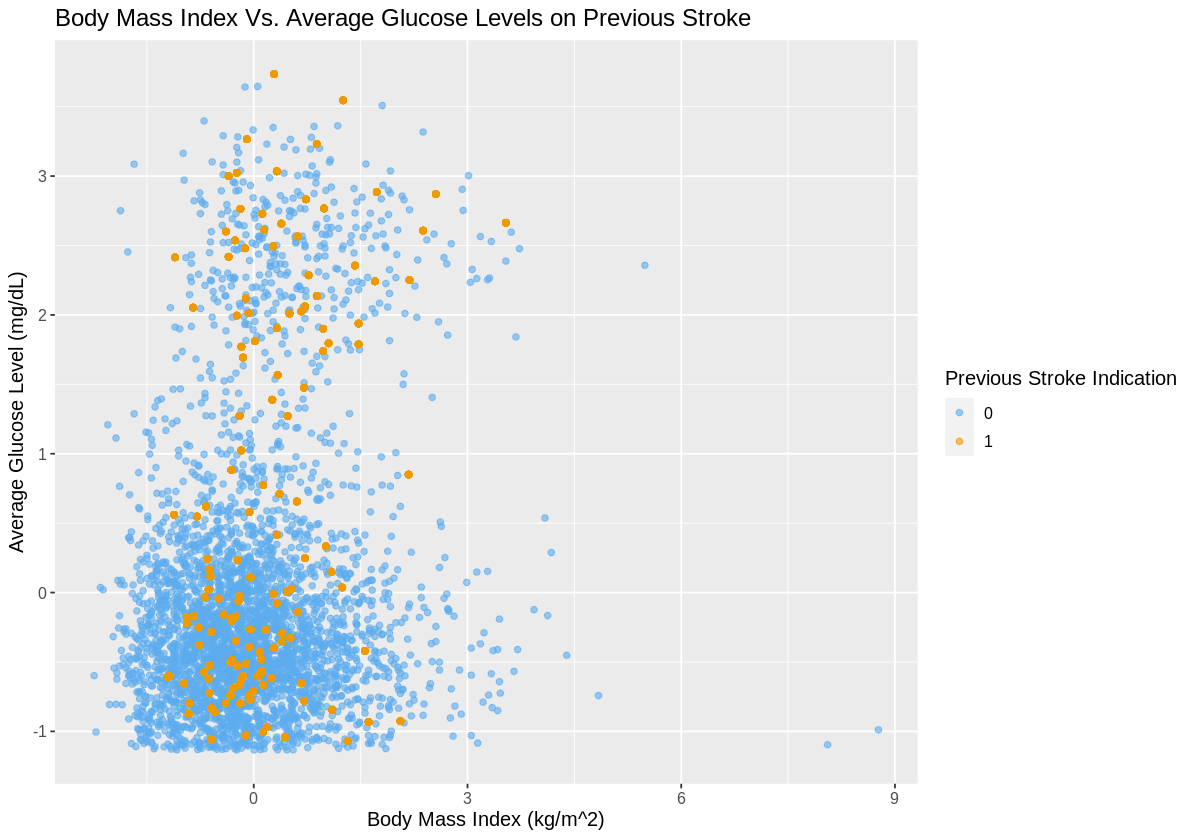

In [23]:
sb_bmi_avg_gluc_plot

Figure 1. Scaled and balanced plot of Body Mass Index Vs. Average Glucose Levels sample set to predict previous strokes

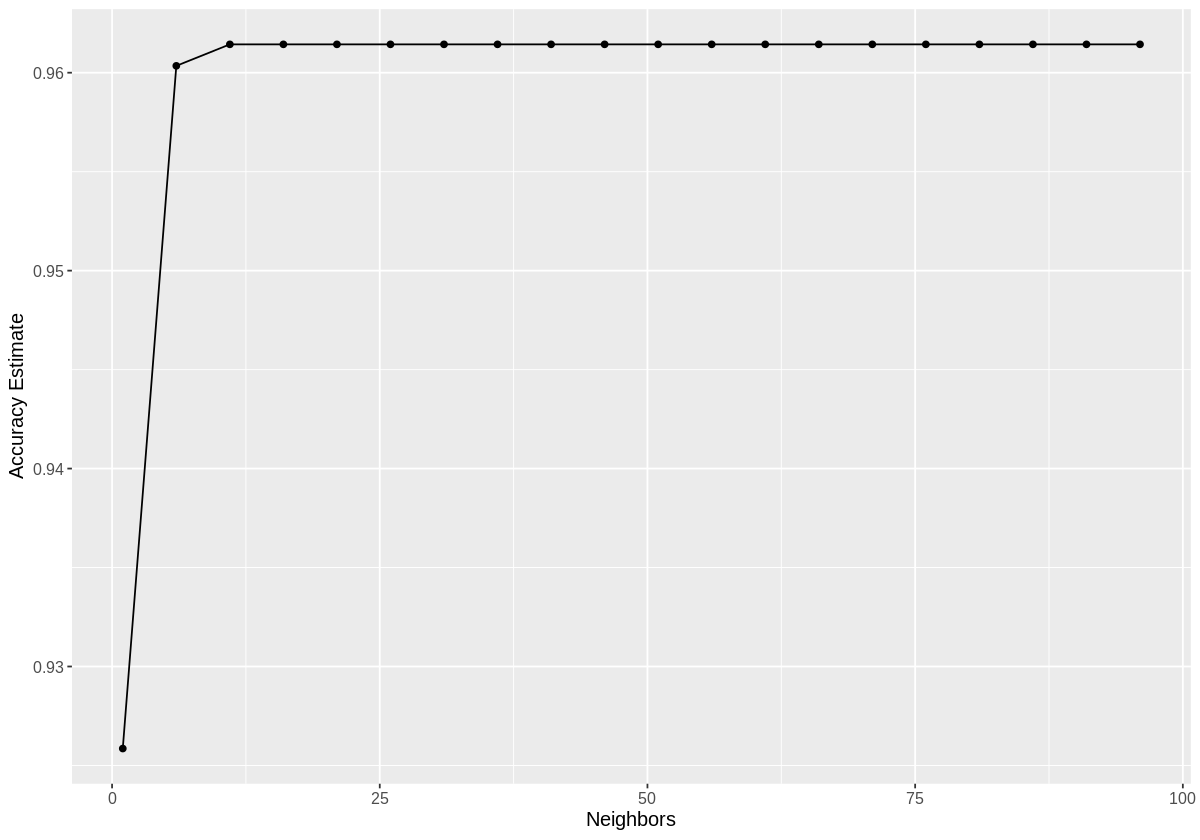

In [33]:
cross_val_plot

Figure 2. Cross Validation K Vs Accuracy Estimate for best K (Choosing K = 11)

In [25]:
best_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 11
  weight_func = rectangular

Computational engine: kknn 


In [26]:
best_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~11, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.038566
Best kernel: rectangular
Best k: 11

Table 6. Final Model Prediction on Stroke Testing Dataset Accuracy Score

In [27]:
stroke_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9453953
kap,binary,0.0000000


Table 7. Confusion Matrix Classifier Predictions Vs Truth Label

In [28]:
stroke_conf_mat

          Truth
Prediction    0    1
         0 1160   67
         1    0    0

### Fix WorkFlow Plot

In [1]:
bmi_grid <- seq(min(stroke_data$bmi), 
                max(stroke_data$bmi), 
                length.out = 100)
agl_grid <- seq(min(stroke_data$avg_glucose_level), 
                max(stroke_data$avg_glucose_level), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(bmi = bmi_grid, 
                                avg_glucose_level = agl_grid))

knnPredGrid <- predict(best_fit, asgrid)

prediction_table <- bind_cols(stroke_predictions, asgrid) %>%
    rename(stroke = .pred_class)


# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = stroke_data_select, 
             mapping = aes(x = bmi, 
                           y = avg_glucose_level, 
                           color = stroke), 
             alpha = 0.6) +
  geom_point(data = prediction_table, 
             mapping = aes(x = bmi, 
                           y = avg_glucose_level, 
                           color = stroke), 
             alpha = 0.02, 
             size = 5) +
    ggtitle("Body Mass Index Vs. Average Glucose Levels on Previous Stroke") +
    labs(color = "Previous Stroke Indication", 
       x = "Body Mass Index (kg/m^2) (standardized)", 
       y = "Average Glucose Level (mg/dL) (standardized)") +
  scale_color_manual(labels = c(0, 1),
                     values = c("steelblue2", "orange2")) +
  theme(text = element_text(size = 12))

wkflw_plot

ERROR: Error in seq(min(stroke_data$bmi), max(stroke_data$bmi), length.out = 100): object 'stroke_data' not found


## Discussion

From the methods and resuts analyzed, the prediction of patients previous strokes using classification method was not as strong due to various issues and indicators.
From the methods and resuts analyzed, the prediction of patients previous strokes using K-nearest neighbors classification was not a strong predictor due to various issues.

Table 2. illustrates the potential selection of a good subset of predictors using the method of forward selection. We see the highest accuracy estimate with predictors bmi and heart disease at a score 0.9578318. The lowest accuracy estimate with predictors bmi, heart disease, hypertension, age, and average glucose level appears at a score of 0.9570171. This model predictor provides only an estimate of the true accuracy, however, the dataset does not indicate the types of heart diseases as such, the use of average glucose levels has been integrated instead.

From Table 6., we can see that using a K-nearest neighbour classifcation tuned with the best K chosen at k = 11, the accuracy score was estimated to be at a value of 0.9453953. This is a very high estimation accuracy for the classifier, however, due to the upsampling used along with cross validation, the classification is more likely to over fit the points in classification to the majority.
         
From Table 7., the confusion matrix shows 1160 observations correctly predicted as cases of no strokes and no correct predictions of stroke cases. However the classifier did make mistakes, it predicted 67 cases of no strokes when they were truly stroke cases. In the cases of predicting strokes, it is not beneficial to have the classifier predict false negatives, as this can result in patients not receiving the appropriate medical attention required. Due to the majority seen in cases of no strokes, it must be the case that the accuracy must be further improved for better predictions of previous strokes.

The analysis models very similar to our predictions previously made such that we were certain there would be a positive relationship between the attribute parameters as predictors for previous stroke. This was seen in the case of the forward selection model. However, as mentioned previously there was a lack of certainty in classifying previous strokes due to the heavy upsampling required. As previoulsy stated, it is known to be a direct cause to overfitting. Each individual data point has a stronger and stronger vote regarding nearby points. Since the data themselves are noisy, this causes a more “jagged” boundary corresponding to a less simple model, which hence impacts the accuracy of our classification model.

The impacts of these findings can further provide added certainty to the use of these attribute paramters of bmi, glucose levels, and hypertension to predict stroke. However, further research must be done to cross check accuracy estimates with respect to proper balancing of the stroke dataset.

This would be an important discovery since our given predictors (bmi, glucose levels, hypertension, etc.) are common medical conditions that are overlooked or treated without regard to long-term side effects, such as the increased potential for strokes (or furthermore, heart disease). While our model does not provide a 100% accuracy, only a close estimate, it could still be used as a method to evaluate a patient’s medical history (with reference to our mentioned predictors) and determine wether they are at potential risk. Performing this evaluation prematurely using our classification model could help the majority of patients avoid the worst-case scenario of stroke occurrence, and begin to take the proper measures (or medical treatments) to actively prevent it.   

In the cases proper balanced is implemented, there can be further predictions using further parameters to solidfy the prediction of previous strokes on patients. As a result, future research could be dedicated to determining if predictions of future stroke instances and concerns to alert patients for medical attention could be possible.

## Works Cited

Boehme, Amelia K., et al. “Stroke Risk Factors, Genetics, and Prevention.” Circulation Research, 3 Feb. 2017, https://www.ahajournals.org/doi/full/10.1161/CIRCRESAHA.116.308398. 

Draper, Norman, and Harry Smith. Applied Regression Analysis. Wiley. 1966.

Eforymson, M. “Stepwise Regression—a Backward and Forward Look.” In Eastern Regional Meetings of the Institute of Mathematical Statistics. 1966.

Hägg-Holmberg, Stefanie, et al. “The Role of Blood Pressure in Risk of Ischemic and Hemorrhagic Stroke in Type 1 Diabetes - Cardiovascular Diabetology.” BioMed Central, BioMed Central, 9 July 2019, https://cardiab.biomedcentral.com/articles/10.1186/s12933-019-0891-4. 

Timbers, Tiffany-Anne, et al. Data Science: An Introduction. CRC Press, 2022. 

Dataset source: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset
Author credentials: fedesoriano